<a href="https://highway.esa.int/">
    <span style=float:left>
        <img src='./img/highway_logo.svg' alt='HIGHWAY' align='center' width='150px'></img>
    </span>
</a>
<a href="https://www.esa.int/">
    <span style=float:right>
        <img src='./img/ESA_logo_2020_White.png' alt='HIGHWAY' align='center' width='250px'></img>
    </span>
</a>

# HIGHWAY Data catalogue


This notebook introduce the HIGHWAY data catalogue.

## Initialisation and connection to the HIGHWAY SERVICE.

In [95]:
import os
import requests
from lib.HIGHWAY_auth import connection_desp
import getpass
import xarray as xr
import colormaps as cmaps

URL_STAC = 'https://ds.highway.esa.int/stac/native'
URL_DATA_SERVICES = 'https://ds.highway.esa.int/'

DATASET_ID = 'L3SW_Open'

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def print_stac_item(print_item):
    # an easy function to print the stac item results.
    print('-' * 40)
    print('id: ' + print_item.get('id', 'non disponible'))
    print('Mission:', print_item.get('properties', {}).get('mission', 'non disponible'))
    print('Start date:', print_item.get('properties', {}).get('start_datetime', 'non disponible'))
    print('Download URL:', URL_DATA_SERVICES + print_item['assets']['file']['href'])



In [96]:
# if you want to test faster, you can create a file password.py with two variable username and password with your own credential
CREDENTIALS_FILE = "password.py"

if os.path.exists(CREDENTIALS_FILE):
    import password as pw

    username = pw.username
    password = pw.password
    print("Using credentials from file.")
else:
    username = getpass.getpass('Type your username: ')
    password = getpass.getpass('Type your password: ')

# HIGHWAY token generation
access_token = connection_desp(username, password)


Using credentials from file.


## Request on collections
First we request the full list of native dataset available on HIGHWAY with the STAC API.

In [97]:
from lib.request_functions import display_stac_dataset

payload = {}
headers = {}

response = requests.request("GET", URL_STAC + '/collections', headers=headers, data=payload)

print()
dataset_list = response.json()['collections']

for dataset in dataset_list[:10]:  # We print only the first ten datasets title.
    print(dataset['title'])



L3_DEBIAS_LOCEAN
L4_SMOS_SMAP_Merged_Brightness_Temperature
SIR_IOPM_2
SIR_IOPN_2
SIR_IOPR_2
SIR_IOP_2_
SIR_NOPM_2
PROBA-V S1 TOC 100 m COG: Data corrected for atmospheric effects with the SMAC (Simplified Method for Atmosheric Corrections) algorithm, COG format - Collection 2
PROBA-V L2A: 100M projected segment data over Antarctica, COG format - Collection 1
PROBA-V S1 TOC 300 m COG: Data corrected for atmospheric effects with the SMAC (Simplified Method for Atmosheric Corrections) algorithm, COG format - Collection 2


In this section we will access the list of items from a dataset

_Note: the request needs the access_token generated previously._

In [98]:
payload = {}
headers = {
    'Authorization': 'Bearer ' + access_token,
}

response = requests.get(URL_STAC + '/collections/' + DATASET_ID + '/items', headers=headers, data=payload)

items = response.json()['features']

for item in items[:10]:  # We print only the first ten products information.
    print_stac_item(item)


----------------------------------------
id: SM_OPER_MIR_SCA3SW_20250721_307_001_7.nc
Mission: SMOS
Start date: 2025-07-21T00:40:29Z
Download URL: https://ds.highway.esa.int//da/download/SMOS/MIR_SCA3SW/307/SM_OPER_MIR_SCA3SW_20250721_307_001_7.nc
----------------------------------------
id: SM_OPER_MIR_SCD3SW_20250721_307_001_7.nc
Mission: SMOS
Start date: 2025-07-21T00:00:00Z
Download URL: https://ds.highway.esa.int//da/download/SMOS/MIR_SCD3SW/307/SM_OPER_MIR_SCD3SW_20250721_307_001_7.nc
----------------------------------------
id: SM_OPER_MIR_SCD3SW_20250720_307_001_7.nc
Mission: SMOS
Start date: 2025-07-20T00:20:50Z
Download URL: https://ds.highway.esa.int//da/download/SMOS/MIR_SCD3SW/307/SM_OPER_MIR_SCD3SW_20250720_307_001_7.nc
----------------------------------------
id: SM_OPER_MIR_SCA3SW_20250720_307_001_7.nc
Mission: SMOS
Start date: 2025-07-20T00:20:07Z
Download URL: https://ds.highway.esa.int//da/download/SMOS/MIR_SCA3SW/307/SM_OPER_MIR_SCA3SW_20250720_307_001_7.nc
--------

Select an ITEM to check

In [99]:
select = input('which of the displayed 10 products do you want to download? (type one number in the range 1-' + str(
    len(items)) + ') : ')
#--------------setting the parameters for the download request----------------

stac_item = items[int(select) - 1]


request the STAC detail for this item

In [100]:
for link in stac_item['links']:
    if link['rel'] == 'self':
        detail_link = link

payload = {}
headers = {
    'Authorization': 'Bearer ' + access_token
}

stac_item_detail = requests.request("GET", detail_link['href'], headers=headers, data=payload).json()

print_stac_item(stac_item_detail)


----------------------------------------
id: SM_OPER_MIR_SCD3SW_20250717_307_001_7.nc
Mission: SMOS
Start date: 2025-07-17T00:37:53Z
Download URL: https://ds.highway.esa.int//da/download/SMOS/MIR_SCD3SW/307/SM_OPER_MIR_SCD3SW_20250717_307_001_7.nc


Now we download the item

In [101]:
payload = {}
headers = {
    'Authorization': 'Bearer ' + access_token
}

response = requests.request("GET", URL_DATA_SERVICES + stac_item_detail['assets']['file']['href'], headers=headers,
                            data=payload)
file_name = stac_item_detail['id']
with open(file_name, 'wb') as f:
    f.write(response.content)


## A visualisation of the product

In [102]:
ds = xr.open_dataset(file_name, decode_coords="all", decode_times=False)

df = ds.to_dataframe()

variables = ds['wind_speed']

variables['latitude'] = variables['lat']
variables['longitude'] = variables['lon']
variables


<xarray.DataArray 'wind_speed' (time: 1, lat: 721, lon: 1440)> Size: 4MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], shape=(1, 721, 1440), dtype=float32)
Coordinates:
  * time       (time) float32 4B 1.298e+04
  * lat        (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon        (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    latitude   (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
    longitude  (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:              retrieved wind speed
    standard_name:          wind_speed
    authority:              CF-1.7
    units:                  m s-1
    coverage_content_type:  physicalMeasurement

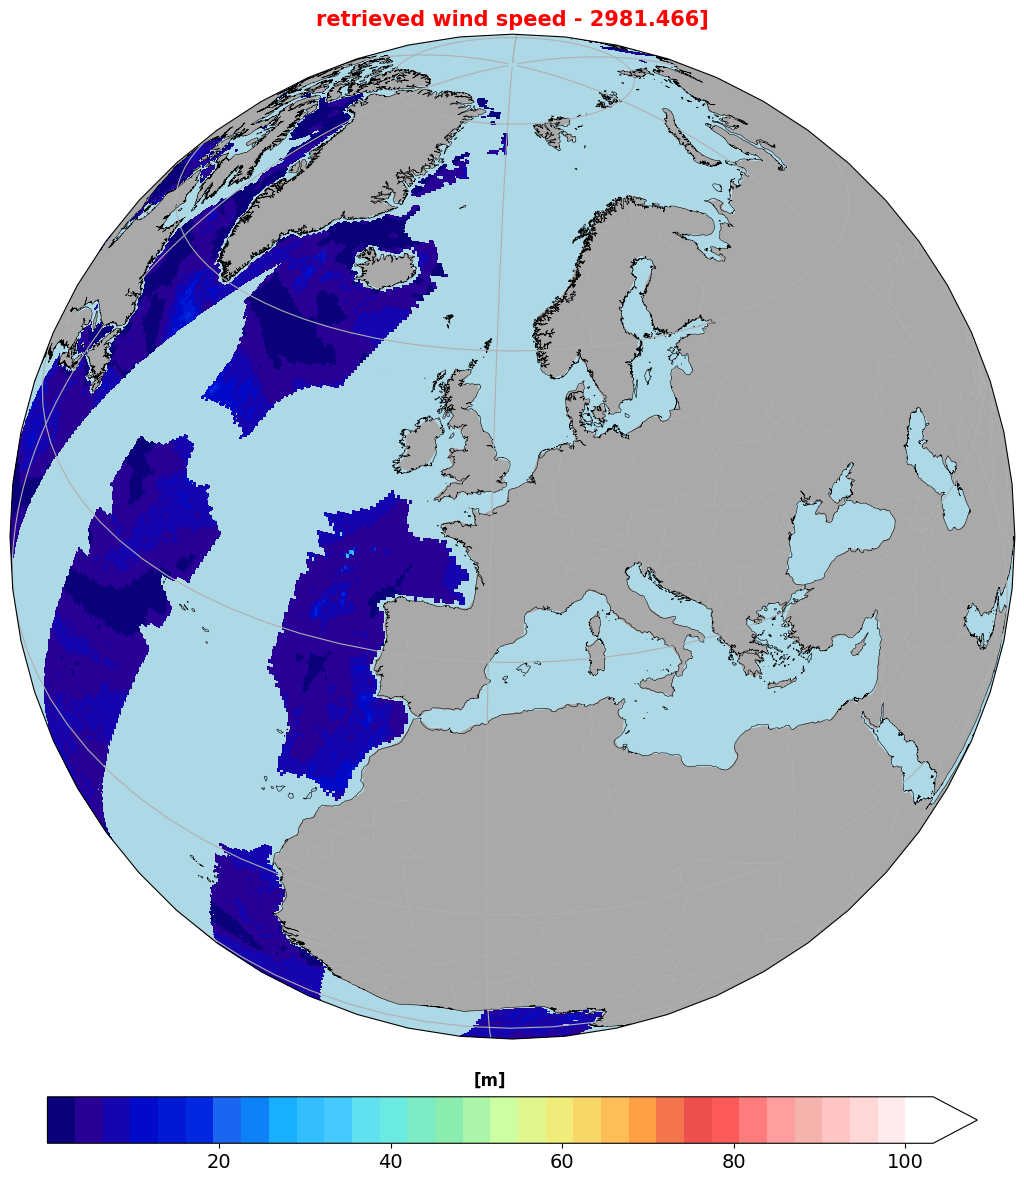

In [103]:
#-----------------data visualization-------------------

values = variables[0, :, :]  # values to plot
latitude = variables.latitude  # matrix of latitude values
longitude = variables.longitude  # matrix of longitude values
date = str(variables['time'].values)[2:12]  # date of acquisition

title = variables.attrs['long_name']  # name of the variable
cmap = cmaps.GMT_haxby

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(
    projection=ccrs.NearsidePerspective(
        central_longitude=2,
        central_latitude=48,
        satellite_height=5500000,
        false_easting=0,
        false_northing=0))
ax.set_global()
img = ax.pcolormesh(longitude, latitude, values, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=0.4, edgecolor='white')
ax.add_feature(cfeature.LAND, facecolor='darkgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='silver')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines()
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.08, pad=0.05, shrink=0.8, extend='max')
cbar.ax.set_title('[m]', fontsize=12, fontweight='bold', pad=8)
cbar.ax.tick_params(labelsize=14)
plt.title(title + " - " + date, fontweight='bold', color='red', fontsize=15)
plt.savefig(file_name.split('.')[0] + '.png', bbox_inches='tight', dpi=300)
plt.show()


Code example provided by <a href='https://adwaiseo.eu/'>adwäisEO</a>

<a href="https://highway.esa.int/">
    <span style=float:left>
        <img src='./img/highway_logo.svg' alt='HIGHWAY' align='center' width='150px'></img>
    </span>
</a>
<a href="https://www.esa.int/">
    <span style=float:right>
        <img src='./img/ESA_logo_2020_White.png' alt='HIGHWAY' align='center' width='250px'></img>
    </span>
</a>